# Results

This notebook is intended as a raw report of the MoveToBeacon challange, where I will discuss all the results (good and bad) that I will get along the way and the ideas obtained from observing them.

In [1]:
from Utils import utils, plot
import numpy as np
import matplotlib.pyplot as plt

# Scripted agent

In [4]:
load_dir = "Results/MoveToBeacon/"
scripted_dict = np.load(load_dir+'scripted_agent_evaluation.npy', allow_pickle=True).item()

In [6]:
mean_score = scripted_dict['mean_score']
std_score = scripted_dict['std_score']
score = scripted_dict['score']

In [28]:
print("Scripted agent score: %.2f +/- %.2f"%(mean_score, std_score))

Scripted agent score: 25.87 +/- 1.91


In [11]:
bins = np.unique(score)-0.5
bins = np.concatenate([bins, np.array([bins[-1]+1])])
bins

array([20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5,
       31.5, 32.5])

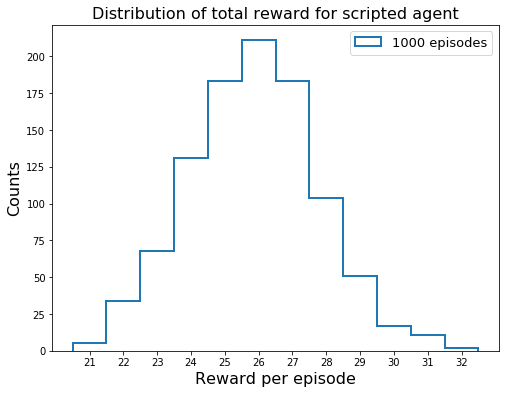

In [27]:
plt.figure(figsize=(8,6))
n, bins, _ = plt.hist(score, bins=bins, histtype='step', lw=2, label='1000 episodes')
plt.xticks(np.arange(21,33))
plt.xlabel("Reward per episode", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.title("Distribution of total reward for scripted agent", fontsize=16)
plt.legend(fontsize=13)
plt.show()

Being random the locations where the beacons are spawned, even the results of a deterministic policy are stochastic because of the game, so we can expect the same for our trained agent.

# Agent 1

In [2]:
load_dir = "Results/MoveToBeacon/"
queries = ['agent1','3000-episodes']
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_agent1_3000-episodes_240-steps_XMLT.npy']


In [3]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]

In [30]:
L = int(len(score)/6)
asymptotic_score = score[-L:].mean()
asymptotic_err = score[-L:].std()
print("Asymptotic performance: %.2f +/- %.2f"%(asymptotic_score, asymptotic_err))
print("Scripted agent score:   %.2f +/- %.2f"%(mean_score, std_score))

Asymptotic performance: 25.66 +/- 1.88
Scripted agent score:   25.87 +/- 1.91


As we can see, the asymptotic performance is almost equal to that of the scripted agent.

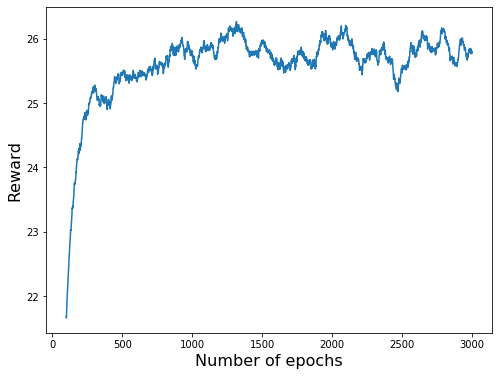

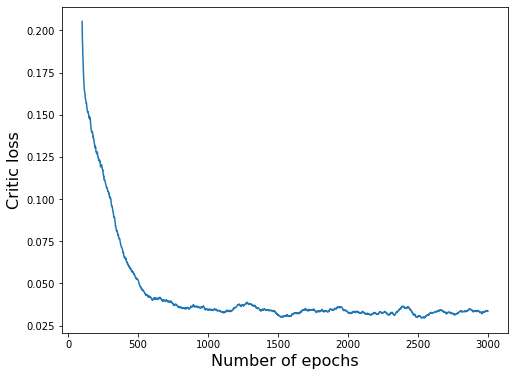

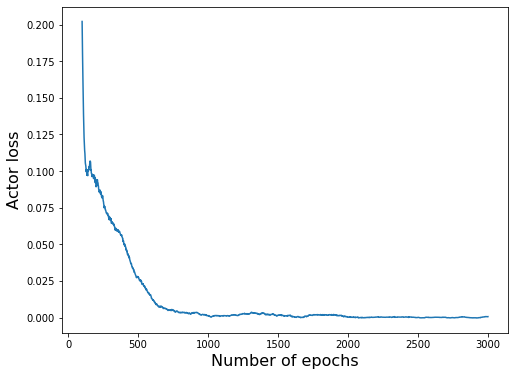

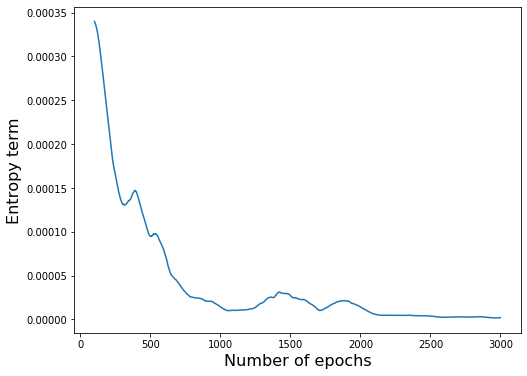

In [5]:
plot.plot_session(score, losses, moving_average=True)

**Results:**
- Convergence: 1000 epochs
- Asymptotic performance: 25.83 +/- 1.85

**Hyper-parameters:**
- Architecture: MLP with hidden dimension [64,32,16] 
- Learning rate: 5e-4 
- Discount factor: 0.9 
- Tau: 0.1 
- n-steps: 40 
- H: 1e-3 
- solver: Adam